##  2. Problem Formulation

---

### **2.1 Type of ML Task**
**Regression**  
- The goal is to **predict a continuous numerical value**: `price`.  
- Regression algorithms are suitable since the target is numeric.

---

### **2.2 Objective**
**Develop a machine learning model capable of accurately predicting house prices** based on property features.  
- Predictive accuracy is the main evaluation criterion.  
- The model should generalize well to unseen data.

---

### **2.3 Data Balance Check**

- Since this is a regression problem, **class imbalance is not directly relevant**.  
- However, it is important to check the **distribution of the target variable (`price`)**.

#### **Price Distribution Insights**
- The `price` data is **right-skewed**:
  - Most houses are **low to moderately priced**.  
  - A few houses are **very expensive**, creating long tails.  

- **Implication:** Right-skewed targets may affect model performance.  
- **Common solution:** Apply a **log transformation** to normalize the distribution.



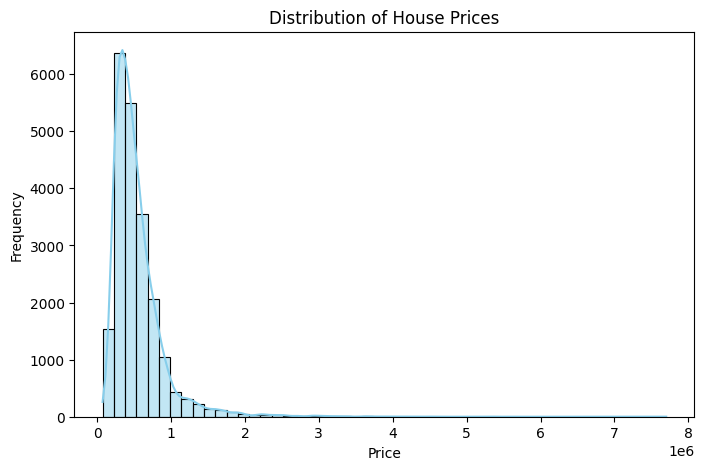

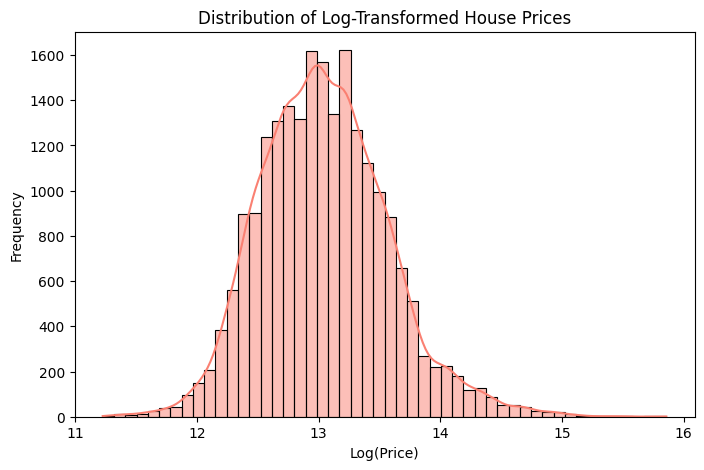

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
data = pd.read_csv('kc_house_data.csv')
# Original price distribution
plt.figure(figsize=(8,5))
sns.histplot(data['price'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Log-transformed price distribution
data['log_price'] = np.log1p(data['price'])  # log1p handles zero values safely
plt.figure(figsize=(8,5))
sns.histplot(data['log_price'], bins=50, kde=True, color='salmon')
plt.title("Distribution of Log-Transformed House Prices")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")
plt.show()


## **2.4 Evaluation Metrics**

For regression tasks, we use metrics that evaluate how close the predicted values are to the actual target values (`price`).

---

### **1. Root Mean Squared Error (RMSE)**
- Measures the **square root of the average squared differences** between predicted and actual values.  
- Sensitive to **large errors (outliers)**.  
- **Lower RMSE → better model performance**.


---

### **2. Mean Absolute Error (MAE)**
- Measures the **average absolute differences** between predicted and actual values.  
- Less sensitive to outliers than RMSE.  
- **Lower MAE → better model performance**.

---

### **3. R² Score (Coefficient of Determination)**
- Measures **proportion of variance explained** by the model.  
- Value ranges from **0 to 1** (sometimes negative if the model is worse than baseline).  
- **R² close to 1 → excellent model performance**.


---

### **✔ Goal**
- **Lower RMSE and MAE** → better predictive accuracy.  
- **R² close to 1** → model explains most of the variance in the target.


## **3. Data Preprocessing**

### **3.1 Train / Validation / Test Split**

Before training the model, we split the dataset into three sets:

| Set          | Proportion | Purpose                                        |
|--------------|------------|-----------------------------------------------|
| Training     | 70%        | Learn patterns from the data                  |
| Validation   | 15%        | Tune hyperparameters and prevent overfitting |
| Test         | 15%        | Evaluate final model performance              |

**Why this split is important:**
- **Training set:** The model learns the relationships between features and the target.  
- **Validation set:** Helps select the best model parameters and avoid overfitting.  
- **Test set:** Provides an unbiased evaluation of the final model’s predictive power.


In [4]:

### **Python Implementation**
from sklearn.model_selection import train_test_split

# Features and target
X = data.drop(columns=['price'])  # or 'log_price' if using log transformation
y = data['price']

# First, split off 30% for validation + test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Then split the 30% into validation and test (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Check sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 15129 samples
Validation set: 3242 samples
Test set: 3242 samples


### **3.2 Handling Missing Data (Specific to This Dataset)**

Upon inspection of the dataset:

- **No NULL or empty values** were found in any column.  
- Some columns contain **0 as placeholders**, which may represent missing-like values:
  - `sqft_basement` → 0 may indicate **no basement**  
  - `yr_renovated` → 0 indicates **never renovated**

---

### **Handling Strategy for This Dataset**

#### **Numeric Columns**
- Replace 0s only if they are **truly missing or meaningless**, otherwise leave them.  
- For example, if treating `sqft_basement=0` as missing:

In [7]:
median_basement = data['sqft_basement'].median()
data['sqft_basement'] = data['sqft_basement'].replace(0, median_basement)


In [12]:
data['sqft_basement'].head(10)

,sqft_basement
0,0
1,400
2,0
3,910
4,0
5,1530
6,0
7,0
8,730
9,0


In [8]:
median_basement

0.0

In [9]:
# No replacement needed
data['sqft_basement'].describe()


,sqft_basement
count,21613.000000
mean,291.509045
std,442.575043
min,0.000000
25%,0.000000
50%,0.000000
75%,560.000000
max,4820.000000


In [10]:
# Create a binary indicator for basement existence
data['basement_exists'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)

# Optional: leave 'sqft_basement' as-is, since 0 is valid
# Or create an imputed version using median of non-zero basements
median_nonzero = data.loc[data['sqft_basement'] > 0, 'sqft_basement'].median()
data['sqft_basement_imputed'] = data['sqft_basement'].replace(0, median_nonzero)

# Check
data[['sqft_basement', 'basement_exists', 'sqft_basement_imputed']].head(10)


,sqft_basement,basement_exists,sqft_basement_imputed
0,0,0,700
1,400,1,400
2,0,0,700
3,910,1,910
4,0,0,700
5,1530,1,1530
6,0,0,700
7,0,0,700
8,730,1,730
9,0,0,700


### **Key Takeaways: `sqft_basement` Handling**

#### **1️⃣ `basement_exists`**
- Binary indicator of whether a basement exists.  
- Helps the model distinguish **houses with no basement (0)** from real basement sizes.  

#### **2️⃣ `sqft_basement_imputed`**
- 0 values replaced by **median of non-zero basements (700 ft²)**.  
- Preserves information for models that may misinterpret 0 as missing.  

#### **3️⃣ Original `sqft_basement`**
- Remains intact, so you can use **either the original or imputed version** depending on model requirements.  

> This is a **best practice** for datasets with **structural zeros**, like `sqft_basement`.


**Categorical Columns**

No missing values, so no imputation needed.

Columns like ``waterfront``, ``view``, ``condition``, ``grade`` are fully populated

### **3.3 Converting Categorical Variables**

Machine learning models require **numeric input**, so categorical features must be encoded appropriately. The type of encoding depends on whether the feature is **ordered (ordinal)** or **unordered (nominal)**.

---

### **1️⃣ One-Hot Encoding (Nominal)**
- Used for **non-ordered categories**.  
- Example in this dataset: `zipcode`  
- Creates **binary columns** for each unique category.



In [13]:

# One-Hot Encoding for zipcode
data = pd.get_dummies(data, columns=['zipcode'], prefix='zip')

In [27]:
# Select all columns that start with 'zip_' (one-hot encoded zipcodes)
zip_columns = [col for col in data.columns if col.startswith('zip_')]

# Show first 5 rows
data[zip_columns].head(5)


,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Label Encoding (Ordinal)**

Used for ordered categories where the order matters.

Examples in this dataset: condition, grade

Converts categories to integer values reflecting their order.

In [18]:
from sklearn.preprocessing import LabelEncoder

# Ordinal encoding
ordinal_cols = ['condition', 'grade']

le = LabelEncoder()
for col in ordinal_cols:
    data[col] = le.fit_transform(data[col])


In [22]:
data[['condition', 'grade']]

,condition,grade
0,2,5
1,2,5
2,2,4
3,4,5
4,2,6
...,...,...
21608,2,6
21609,2,6
21610,2,5
21611,2,6


**Notes :**

*  After encoding, all features are numeric, ready for machine learning algorithms.

*  One-Hot Encoding avoids introducing false order in nominal features.

*  Label Encoding preserves the natural order for ordinal features.

### **3.4 Scaling Numeric Features**

Scaling numeric features is an important preprocessing step for certain machine learning algorithms.  
It ensures that features are on a similar scale, which improves **model performance and convergence**.

---

### **1️⃣ When Scaling is Important**
Algorithms sensitive to feature scale include:

- **Linear Regression**  
- **K-Nearest Neighbors (KNN)**  
- **Support Vector Machines (SVM)**  
- **Neural Networks**

---

### **2️⃣ Scaling Methods**

#### **StandardScaler**
- Centers features to **mean = 0** and **std = 1**.  
- Useful when features have different units and large variance.


In [28]:
from sklearn.preprocessing import StandardScaler

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [29]:
data[numeric_cols].head(5)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,log_price,basement_exists,sqft_basement_imputed
0,0.886146,-0.866717,-0.398737,-1.447464,-0.979835,-0.228321,-0.915427,-0.087173,-0.305759,-0.629187,...,-0.658681,-0.544898,-0.210128,-0.352572,-0.306079,-0.943355,-0.260715,-1.400936,-0.804102,-0.065307
1,0.637511,-0.005688,-0.398737,0.175607,0.533634,-0.189885,0.936506,-0.087173,-0.305759,-0.629187,...,0.245141,-0.681079,4.746678,1.161568,-0.746341,-0.432686,-0.187868,0.280624,1.243624,-1.243226
2,0.365444,-0.980849,-1.473959,-1.447464,-1.426254,-0.123298,-0.915427,-0.087173,-0.305759,-0.629187,...,-0.658681,-1.293892,-0.210128,1.283537,-0.135655,1.070140,-0.172375,-1.798279,-0.804102,-0.065307
3,-0.727656,0.174090,0.676485,1.149449,-0.130550,-0.244014,-0.915427,-0.087173,-0.305759,2.444294,...,1.397515,-0.204446,-0.210128,-0.283288,-1.271816,-0.914174,-0.284522,0.500335,1.243624,0.759236
4,-0.912881,-0.081958,-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,-0.087173,-0.305759,-0.629187,...,-0.658681,0.544548,-0.210128,0.409550,1.199335,-0.272190,-0.192849,0.179141,-0.804102,-0.065307


**MinMaxScaler**

Scales features to a fixed range [0, 1].

Useful for algorithms that require bounded input (e.g., neural networks with sigmoid activation).

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [31]:
data[numeric_cols].head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,log_price,basement_exists,sqft_basement_imputed
0,0.720103,0.019266,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.5,...,0.000000,0.478261,0.000000,0.571498,0.217608,0.161934,0.005742,0.234208,0.0,0.143451
1,0.647853,0.060721,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.5,...,0.082988,0.443478,0.988089,0.908959,0.166113,0.222165,0.008027,0.425428,1.0,0.081081
2,0.568795,0.013770,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.5,...,0.000000,0.286957,0.000000,0.936143,0.237542,0.399415,0.008513,0.189024,0.0,0.143451
3,0.251157,0.069377,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.0,...,0.188797,0.565217,0.000000,0.586939,0.104651,0.165376,0.004996,0.450413,1.0,0.187110
4,0.197333,0.057049,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.5,...,0.000000,0.756522,0.000000,0.741354,0.393688,0.241094,0.007871,0.413888,0.0,0.143451


##**3️⃣ When Scaling is NOT Needed**

Tree-based models like:

*  Random Forest

*  XGBoost

These models are scale-invariant, so scaling numeric features is optional.

**Notes :**

*  Always fit the scaler on training data only, then transform validation/test sets to avoid data leakage:

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### ✅ **4. Feature Importance**

---

## **4.1 Correlation Analysis**

Correlation analysis helps identify which features have the strongest relationship with the target variable **price**.

### **Key Insights (Typical for House Price Data)**

- **`sqft_living` → Strong positive correlation**  
  Larger interior size increases price.

- **`grade` → Strong positive correlation**  
  Higher construction/quality grade = higher price.

- **`bathrooms` → Moderate correlation**  
  More bathrooms usually means a more expensive house.

- **`sqft_lot` → Weak correlation**  
  Lot size contributes little unless extremely large.

- **`zipcode` → Mixed correlation**  
  Some neighborhoods are expensive, others are not.

- **`sqft_living` and `sqft_above` are highly correlated**  
  → Potential redundancy.

### **Purpose of Correlation Analysis**
- Identify **important predictive features**
- Detect **redundant or highly correlated features**  
  (helps with feature selection and reducing multicollinearity)


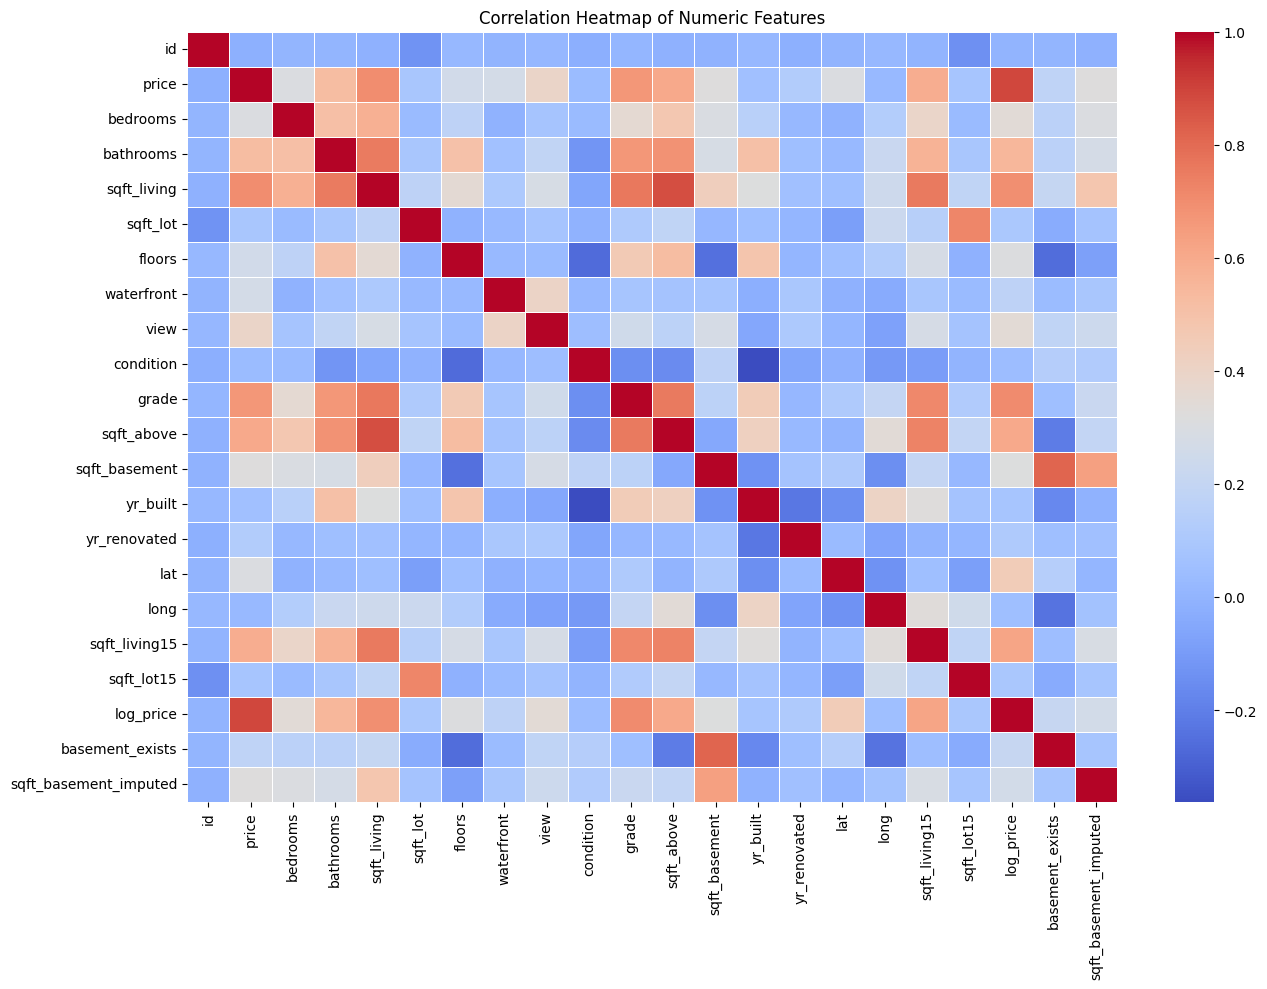

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [34]:
# Sort correlations with price
price_corr = corr_matrix['price'].sort_values(ascending=False)

print("🔝 Top Correlated Features with Price:")
print(price_corr.head(10))


🔝 Top Correlated Features with Price:
price                    1.000000
log_price                0.891654
sqft_living              0.702035
grade                    0.667529
sqft_above               0.605567
sqft_living15            0.585379
bathrooms                0.525138
view                     0.397293
sqft_basement            0.323816
sqft_basement_imputed    0.320784
Name: price, dtype: float64


In [35]:
print("🔽 Least Correlated Features with Price:")
print(price_corr.tail(10))


🔽 Least Correlated Features with Price:
waterfront         0.266369
floors             0.256794
basement_exists    0.180230
yr_renovated       0.126434
sqft_lot           0.089661
sqft_lot15         0.082447
yr_built           0.054012
condition          0.036362
long               0.021626
id                -0.016762
Name: price, dtype: float64


## ✅ **4.2 Feature Importance from ML Models**

Tree-based machine learning models naturally provide **feature importance scores** based on how much each feature reduces prediction error.

These models do **not** require scaling and work well with non-linear relationships:

- **RandomForestRegressor**
- **XGBoost Regressor**
- **GradientBoosting Regressor**

---

### **🔥 Common Features with Highest Importance**
Across most tree-based models, the following features usually rank highest:

- **`sqft_living`** — strongest driver of price  
- **`grade`** — overall construction quality  
- **`sqft_above`** — main living area size  
- **`bathrooms`** — more bathrooms = higher value  
- **`lat`** — location effect  
- **`view`** — better view = more expensive  


## ✅ **4.3 Why Delete Certain Features?**

Some features do not contribute to the predictive power of the model, or they introduce noise, redundancy, or unnecessary complexity.  
Below is a list of features that are commonly removed and the reasoning behind each decision.

---

### **🗑️ Features Considered for Deletion**

| **Feature**      | **Reason for Deletion** |
|------------------|--------------------------|
| **id**           | Unique identifier — carries **no predictive value**. |
| **date**         | Raw date string is not useful. <br> ✔ Better to extract **year**, **month**, **day** instead. |
| **sqft_lot**     | Shows **very weak correlation** with price and often adds noise. |
| **zipcode**      | After one-hot encoding, creates **too many columns** → risk of overfitting & high memory usage. <br> ✔ Better alternative: use **lat/long** for geographic information. |
| **yr_renovated** | Mostly **zeros** → behaves like a binary feature. <br> ✔ Better to use `is_renovated` flag. |

---

### 🎯 **Goal of Feature Deletion**
- Reduce **overfitting**
- Improve **model performance**
- Lower computational cost
- Remove **irrelevant or misleading variables**
- Improve interpretability of the model

---

###  We can :

- Replace `date` → with **year, month, day**
- Replace `yr_renovated` → with **is_renovated = (yr_renovated > 0)**  
- Replace `zipcode` → rely more on **lat** + **long**

These transformations retain the useful information while avoiding problems caused by the raw features.
